In [1]:
from sigvisa.treegp.gp import GPCov, GP, mcov, prior_sample
import scipy.stats
import scipy.optimize

In [2]:
from autograd import grad, value_and_grad
import autograd.numpy as np


def cov_matrix(X1, X2, theta):
    # SE cov with ARD, theta specifies variance and lengthscales (diagonals of W matrix)
    n1, d = X1.shape
    n2, d = X2.shape
    assert(len(theta)==d+1)
    s2 = theta[0]
    lscales = theta[1:]

    rows = []
    for i in range(n1):
        row = []
        for j in range(n2):
            diff = X1[i,:] - X2[j,:]
            sdiff = np.sum(diff**2 / lscales)
            row.append(np.exp(-.5*sdiff))
        rows.append(row)
    K = np.array(rows)
    return s2*K

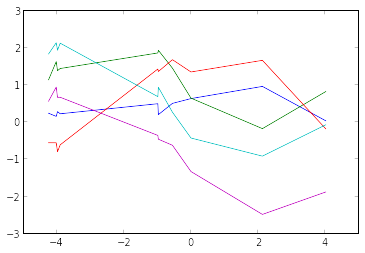

In [3]:
# sample data from the prior
X = np.asarray(sorted(np.random.rand(10)*10-5)).reshape((-1,1))

cov = GPCov(wfn_params=[1.0], dfn_params=[1.0,], dfn_str="euclidean", wfn_str="se")
noise_var = 0.01
true_theta = [1.0, 2.0]
KK = cov_matrix(X, X, true_theta) + np.eye(X.shape[0])*noise_var

y = scipy.stats.multivariate_normal(mean=np.zeros((X.shape[0],)), cov=KK).rvs(5)
YY = np.dot(y.T, y)
#y = np.array([prior_sample(X, cov, noise_var) for i in range(5)])

for i in range(y.shape[0]):
    plot(X, y[i,:])


In [13]:
def gplik(x):
    X = x.reshape((-1,1))
    K = cov_matrix(X, X, [1.0, 3.0]) + np.eye(X.shape[0])*noise_var
    return -gaussian_lik(y, means=np.zeros(y.shape), cov=K)
    


def gaussian_lik(ys, means, cov):
    Kinv = np.linalg.inv(cov)
    logdet = np.log(np.linalg.det(cov))
    ll = 0
    for y,m in zip(ys, means):
        r = y-m
        ll += -.5 * np.dot(r.T, np.dot(Kinv, r)) - .5*logdet -.5*len(r)*np.log(2*np.pi)
    return ll

invKK = np.linalg.inv(KK)
def test_dist(test_X):
    test_Xt = cov_matrix(test_X, X, true_theta)
    K_test = cov_matrix(test_X, test_X, true_theta) + np.eye(1)*noise_var
    tmp = np.dot(test_Xt, invKK)
    conditional_cov = K_test - np.dot(tmp, test_Xt.T)
    conditional_means = [np.dot(tmp, yy) for yy in y]
    return conditional_means, conditional_cov


# sample observed values for a test point at a known location
test_X = np.array(0.5).reshape((1,1))
m, c = test_dist(test_X)
test_ys = [scipy.stats.multivariate_normal(mean=mm, cov=c).rvs(1) for mm in m]
print test_ys



[-1.077548988726226, 1.3867124054030193, 0.85459765290490741, -0.84077320600549899, 0.27438446079932644]


   status: 0
  success: True
     njev: 8
     nfev: 8
 hess_inv: array([[ 0.00516876]])
      fun: -3.508392650099577
        x: array([ 0.44782254])
  message: 'Optimization terminated successfully.'
      jac: array([  1.81021087e-09])


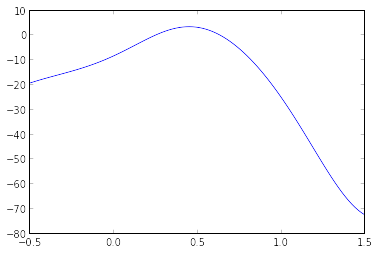

In [44]:
# locate the test point under the full GP model

def test_lik(test_X):
    test_X = np.array(test_X).reshape((-1, 1))
    means, cov = test_dist(test_X)
    return -gaussian_lik(test_ys, means, cov)
                           
xs = np.linspace(-0.5, 1.5, 100)
lls = [-test_lik(xx) for xx in xs]
plot(xs, lls)

j = value_and_grad(test_lik)
r = scipy.optimize.minimize(j, np.array((0.5)), jac=True)
print r


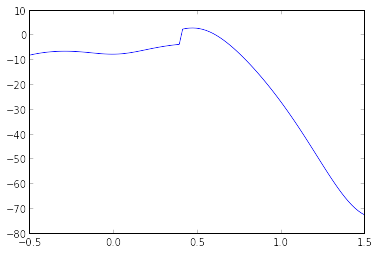

In [43]:
# locate the test point under a local GP model

thresh = 0.4

mask = X.flatten()<thresh
X1 = (X[mask]).reshape((-1,1))
X2 = X[~mask].reshape((-1,1))


K1 = cov_matrix(X1, X1, true_theta) + np.eye(X1.shape[0])*noise_var
K2 = cov_matrix(X2, X2, true_theta) + np.eye(X2.shape[0])*noise_var

invK1 = np.linalg.inv(K1)
invK2 = np.linalg.inv(K2)

Y1 = y[:, mask]
Y2 = y[:, ~mask]

def lgp_dist(test_X):
    if test_X < thresh:
        K = K1
        XT = X1
        invK = invK1
        Y = Y1
    else:
        K = K2
        XT = X2
        invK = invK2
        Y = Y2
        
    test_Xt = cov_matrix(test_X, XT, true_theta)
    K_test = cov_matrix(test_X, test_X, true_theta) + np.eye(1)*noise_var
    tmp = np.dot(test_Xt, invK)
    conditional_cov = K_test - np.dot(tmp, test_Xt.T)
    conditional_means = [np.dot(tmp, yy) for yy in Y]
    return conditional_means, conditional_cov

def local_lik(test_X):    
    test_X = np.array(test_X).reshape((-1, 1))
    means, cov = lgp_dist(test_X)
    return -gaussian_lik(test_ys, means, cov)

xs = np.linspace(-0.5, 1.5, 100)
lls = [-local_lik(xx) for xx in xs]
plot(xs, lls)

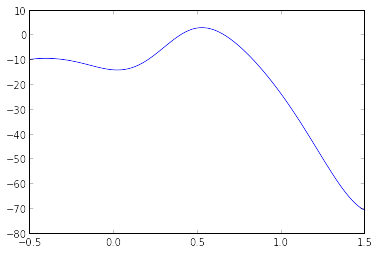

In [42]:
def bcm_combine(means, covs, prior_cov):
    n = len(means)
    allprec = -(n-1)*np.linalg.inv(prior_cov)
    allmean = np.zeros((prior_cov.shape[0]),)
    for (mean, cov) in zip(means, covs):
        prec = np.linalg.inv(cov)
        allprec += prec
        allmean += np.dot(prec, mean)
    cov = np.linalg.inv(allprec)
    mean = np.dot(cov, allmean)
    return mean, cov

def bcm_dist(test_X):
    if test_X < thresh:
        K = K1
        XT = X1
        invK = invK1
        Y = Y1
    else:
        K = K2
        XT = X2
        invK = invK2
        Y = Y2
        
    test_Xt1 = cov_matrix(test_X, X1, true_theta)
    test_Xt2 = cov_matrix(test_X, X2, true_theta)

    K_test = cov_matrix(test_X, test_X, true_theta) + np.eye(1)*noise_var
    
    tmp1 = np.dot(test_Xt1, invK1)
    tmp2 = np.dot(test_Xt2, invK2)
    
    conditional_cov1 = K_test - np.dot(tmp1, test_Xt1.T)
    conditional_means1 = [np.dot(tmp1, yy) for yy in Y1]
    
    conditional_cov2 = K_test - np.dot(tmp2, test_Xt2.T)
    conditional_means2 = [np.dot(tmp2, yy) for yy in Y2]
    
    conditional_means = []
    for (m1, m2) in zip(conditional_means1, conditional_means2):
        m, c = bcm_combine((m1, m2), (conditional_cov1, conditional_cov2), K_test)
        conditional_means.append(m)
        conditional_cov = c
        
    return conditional_means, conditional_cov

def bcm_lik(test_X):    
    test_X = np.array(test_X).reshape((-1, 1))
    means, cov = bcm_dist(test_X)
    return -gaussian_lik(test_ys, means, cov)


xs = np.linspace(-0.5, 1.5, 100)
lls = [-bcm_lik(xx) for xx in xs]
plot(xs, lls)

[[ 0.45656325]
 [ 0.55789284]
 [ 1.45266777]
 [ 1.49484029]
 [ 1.50994943]
 [ 1.68714256]
 [ 2.76239264]]
